# Northwind Trades ® - Enhancing Product Recommendations and Warehouse Efficiency through Data-Driven Analytics
## Part 1: PostgreSQL Data Loading

### Database Schema for this Project

Northwind is a database comprising numerous tables. Our project utilizes a subset of these, including the following:

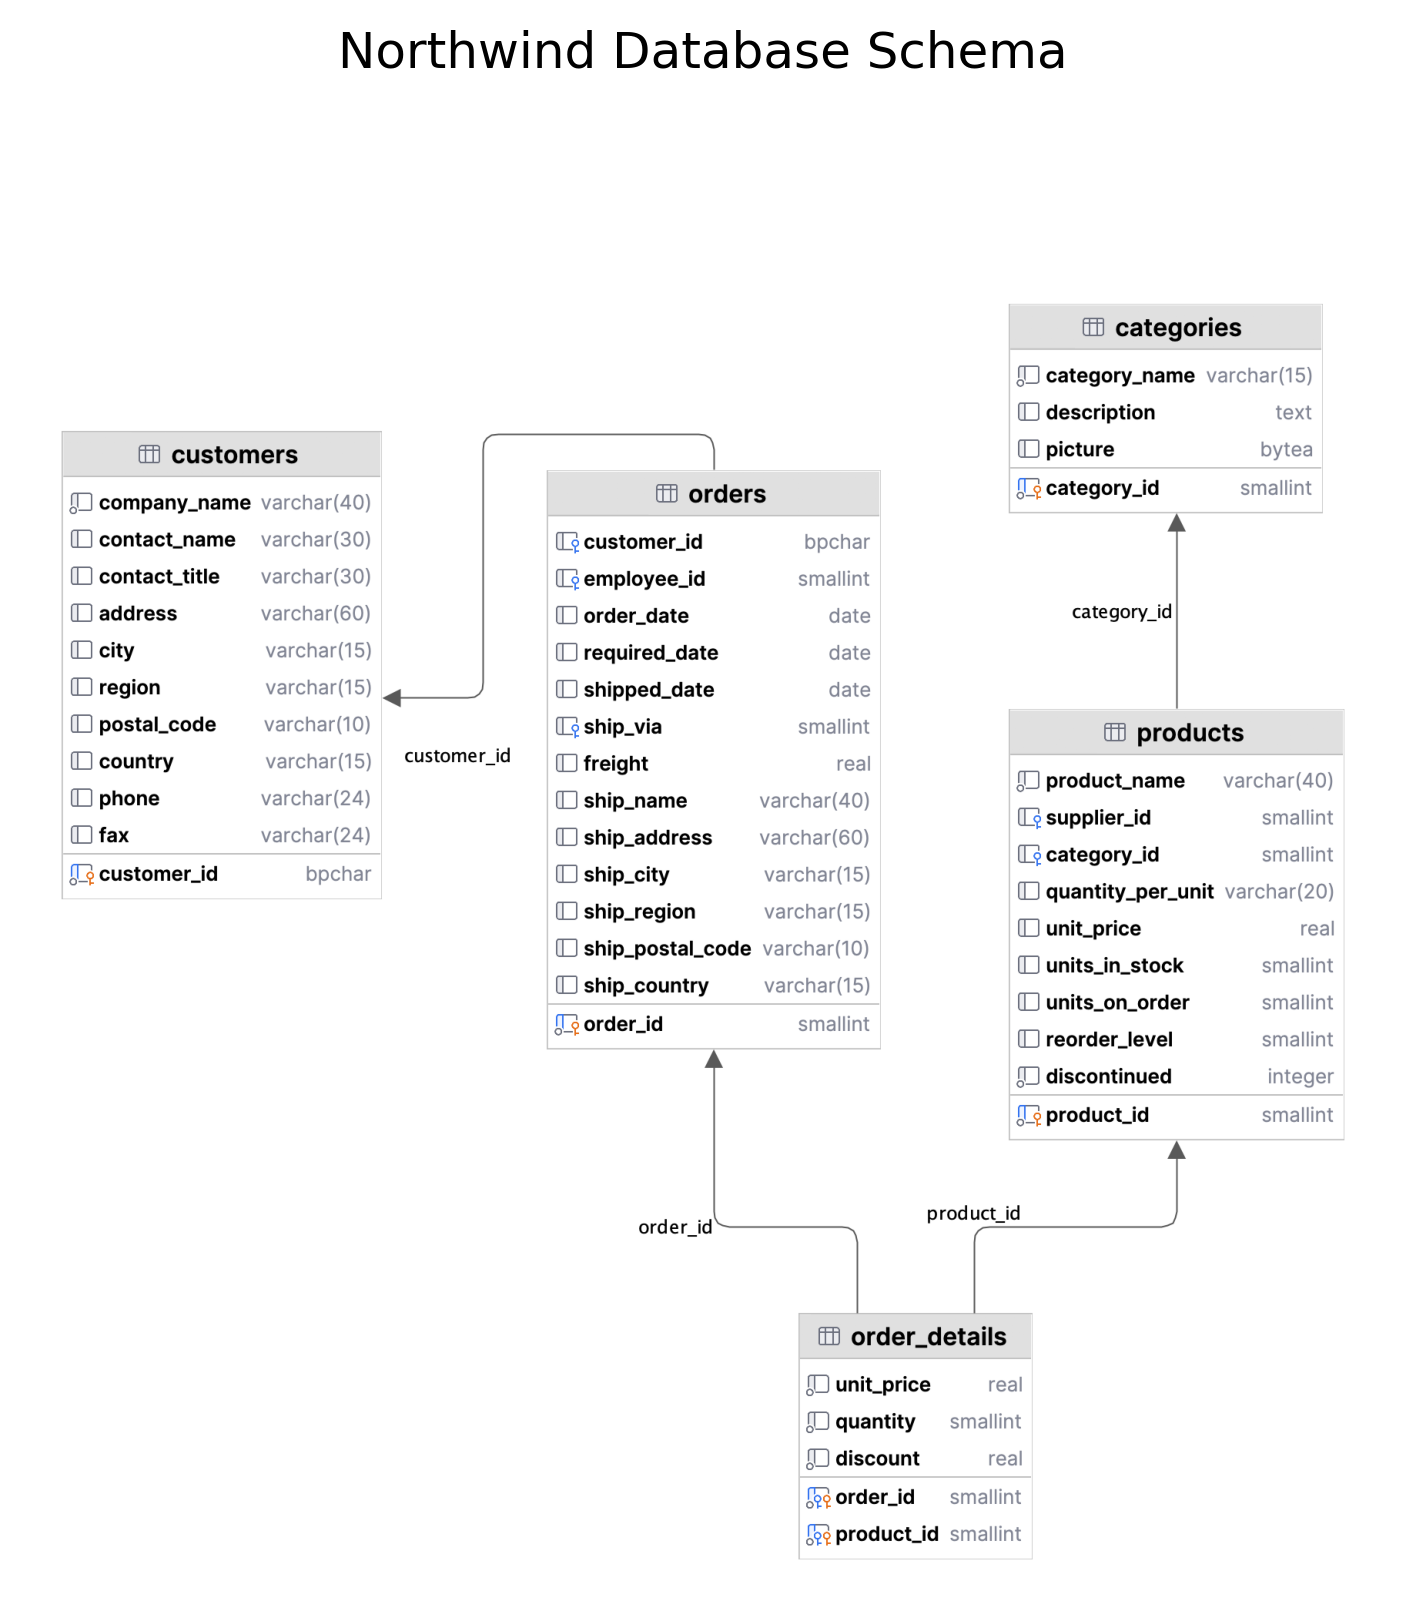

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


def show_image(image_path: str, title: str, dpi: int = 300) -> None:
    img = mpimg.imread(image_path)
    plt.figure(dpi=dpi, figsize=(img.shape[1] / dpi, img.shape[0] / dpi))
    plt.title(title)

    # Remove x and y ticks
    plt.xticks([])
    plt.yticks([])

    # Remove the axis (borders)
    plt.axis('off')

    plt.imshow(img)
    plt.show()


show_image("images/postgres_schema.png", "Northwind Database Schema")

### Included Modules, Packages, and Supporting Functions

In [2]:
import warnings
import math

import numpy as np
import pandas as pd
import psycopg2

warnings.filterwarnings("ignore", category=UserWarning, message="pandas only supports SQLAlchemy connectable")

### Loading Schema and Data into PostgreSQL

In [3]:
from psycopg2._psycopg import connection
import platform
import getpass


def generate_postgres_mids_conn() -> connection:
    if platform.system() == "Darwin" and getpass.getuser() == "honghu":
        return psycopg2.connect(
            user="postgres",
            password="abc123",
            host="localhost",
            port="5433",
            database="postgres"
        )
    else:
        return psycopg2.connect(
            user="postgres",
            password="ucb",
            host="postgres",
            port="5432",
            database="postgres"
        )


def exec_sql(sql: str, conn: connection = None, cursor=None, params: list = None) -> None:
    """
    execute sql
    :param sql: sql statement
    :param conn: connection
    :param cursor: default cursor
    :param params: query parameters
    """
    if conn is None:
        with generate_postgres_mids_conn() as conn:
            return exec_sql(sql, conn, cursor, params)
    if cursor is None:
        with conn.cursor() as cursor:
            return exec_sql(sql, conn, cursor, params)
    conn.rollback()
    if params is not None:
        cursor.execute(sql, params)
    else:
        cursor.execute(sql)
    conn.commit()


def load_northwind(conn: connection) -> None:
    """
    Resets the Northwind database by executing the DDL and data SQL scripts.
    """
    with open("sql/northwind_ddl.sql") as f:
        northwind_ddl = f.read()
        exec_sql(northwind_ddl, conn)
    with open("sql/northwind_data.sql") as f:
        northwind_data = f.read()
        exec_sql(northwind_data, conn)

In [4]:
conn = generate_postgres_mids_conn()
load_northwind(conn)

### Verify the Customers Loaded Correctly

In [5]:
def my_select_query_pandas(
        query: str, params: list = None, conn: connection = None, rollback_before_flag: bool = True,
        rollback_after_flag: bool = True
) -> pd.DataFrame:
    """
    function to run a select query and return rows in a pandas dataframe

    :param query: The SQL query to execute.
    :param params: The parameters to pass to the query. Defaults to None.
    :param conn: The database connection to use. Defaults to a generated Postgres connection.
    :param rollback_before_flag: If True, performs a rollback before executing the query. Defaults to True.
    :param rollback_after_flag: If True, performs a rollback after executing the query. Defaults to True.
    :return: A pandas DataFrame containing the query results.
    """
    if conn is None:
        with generate_postgres_mids_conn() as new_conn:
            return my_select_query_pandas(query, params, new_conn, rollback_before_flag, rollback_after_flag)

    if rollback_before_flag:
        conn.rollback()

    if params is not None:
        df = pd.read_sql_query(query, conn, params=params)
    else:
        df = pd.read_sql_query(query, conn)

    if rollback_after_flag:
        conn.rollback()

    # fix the float columns that really should be integers
    for column in df:
        if df[column].dtype == "float64":
            fraction_flag = False
            for value in df[column].values:
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True
            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    return df

In [6]:
sql = """
select customer_id, company_name, country 
from customers
order by country, customer_id
"""
my_select_query_pandas(query=sql, conn=conn)

,customer_id,company_name,country
0,CACTU,Cactus Comidas para llevar,Argentina
1,OCEAN,Océano Atlántico Ltda.,Argentina
2,RANCH,Rancho grande,Argentina
3,ERNSH,Ernst Handel,Austria
4,PICCO,Piccolo und mehr,Austria
...,...,...,...
86,WHITC,White Clover Markets,USA
87,GROSR,GROSELLA-Restaurante,Venezuela
88,HILAA,HILARION-Abastos,Venezuela
89,LILAS,LILA-Supermercado,Venezuela


### Verify the Product Categories Loaded Correctly

In [7]:
sql = """
select category_id, category_name, description
from categories
order by category_id
"""
my_select_query_pandas(query=sql, conn=conn)

,category_id,category_name,description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"
5,6,Meat/Poultry,Prepared meats
6,7,Produce,Dried fruit and bean curd
7,8,Seafood,Seaweed and fish


### Verify the Products Loaded Correctly

In [8]:
sql = """
select product_id, product_name, categories.category_name 
from products
join categories on products.category_id = categories.category_id
order by product_id
"""
my_select_query_pandas(query=sql, conn=conn)

,product_id,product_name,category_name
0,1,Chai,Beverages
1,2,Chang,Beverages
2,3,Aniseed Syrup,Condiments
3,4,Chef Anton's Cajun Seasoning,Condiments
4,5,Chef Anton's Gumbo Mix,Condiments
...,...,...,...
72,73,Röd Kaviar,Seafood
73,74,Longlife Tofu,Produce
74,75,Rhönbräu Klosterbier,Beverages
75,76,Lakkalikööri,Beverages


### Verify the Orders Loaded Correctly

In [9]:
sql = """
select orders.order_id, customers.customer_id, products.product_name, order_details.unit_price, order_details.quantity
from orders
join order_details on orders.order_id = order_details.order_id
join products on order_details.product_id = products.product_id
join customers on orders.customer_id = customers.customer_id
order by orders.order_id, customers.customer_id, products.product_name
"""
my_select_query_pandas(query=sql, conn=conn)

,order_id,customer_id,product_name,unit_price,quantity
0,10248,VINET,Mozzarella di Giovanni,34.80,5
1,10248,VINET,Queso Cabrales,14.00,12
2,10248,VINET,Singaporean Hokkien Fried Mee,9.80,10
3,10249,TOMSP,Manjimup Dried Apples,42.40,40
4,10249,TOMSP,Tofu,18.60,9
...,...,...,...,...,...
2150,11077,RATTC,Spegesild,12.00,3
2151,11077,RATTC,Tofu,23.25,1
2152,11077,RATTC,Tunnbröd,9.00,2
2153,11077,RATTC,Uncle Bob's Organic Dried Pears,30.00,1
